In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tqdm import tqdm
import sys

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from evaluate_metrics import compute_eer

## DF2021

In [2]:
# load DF 2021 metadata
DF21 = pd.read_csv('/datab/Dataset/ASVspoof/LA/ASVspoof2021_keys/DF/CM/trial_metadata.txt', sep=' ', header=None)
DF21.columns = ['sid', 'utt', 'codec', 'src', 'attack', 'label', 'trimed', 'subset', 'vocoder', 's1', 's2', 's3', 's4']
DF21.head


<bound method NDFrame.head of             sid           utt     codec       src        attack  label  \
0       LA_0023  DF_E_2000011   nocodec  asvspoof           A14  spoof   
1          TEF2  DF_E_2000013   low_m4a   vcc2020  Task1-team20  spoof   
2          TGF1  DF_E_2000024    mp3m4a   vcc2020  Task2-team12  spoof   
3       LA_0043  DF_E_2000026    mp3m4a  asvspoof           A09  spoof   
4       LA_0021  DF_E_2000027    mp3m4a  asvspoof           A12  spoof   
...         ...           ...       ...       ...           ...    ...   
611824  VCC2TM2  DF_E_4999945    oggm4a   vcc2018       SPO-N16  spoof   
611825  LA_0044  DF_E_4999962    oggm4a  asvspoof           A19  spoof   
611826  LA_0042  DF_E_4999964  high_ogg  asvspoof           A13  spoof   
611827     TEM1  DF_E_4999980   low_m4a   vcc2020  Task1-team07  spoof   
611828     TGF1  DF_E_4999993    mp3m4a   vcc2020  Task2-team33  spoof   

        trimed    subset                           vocoder     s1      s2  s3  \


In [3]:
# Samples 10000 randomly from the DF21 dataset
# DF21_10000 = DF21.sample(n=10000, random_state=1)
# DF21_10000.head

# sample 5000 bonafide
DF21_bona = DF21[DF21['label'] == 'bonafide'].sample(n=5000, random_state=1)
# sample 5000 spoof
DF21_spoof = DF21[DF21['label'] == 'spoof'].sample(n=5000, random_state=1)
# concat
DF21_10000 = pd.concat([DF21_bona, DF21_spoof])
DF21_10000.head

<bound method NDFrame.head of             sid           utt     codec       src        attack     label  \
262543  LA_0019  DF_E_3286133   low_ogg  asvspoof             -  bonafide   
372928  LA_0017  DF_E_3827859   low_mp3  asvspoof             -  bonafide   
349253  LA_0039  DF_E_3710666    mp3m4a  asvspoof             -  bonafide   
89993   LA_0038  DF_E_2441351  high_mp3  asvspoof             -  bonafide   
259494  VCC2SF2  DF_E_3270860   low_ogg   vcc2018             -  bonafide   
...         ...           ...       ...       ...           ...       ...   
23996   LA_0024  DF_E_2118638   low_mp3  asvspoof           A12     spoof   
49446      TEM2  DF_E_2242469    oggm4a   vcc2020  Task1-team19     spoof   
506567     TEF2  DF_E_4483286    oggm4a   vcc2020  Task1-team04     spoof   
415577  VCC2TF2  DF_E_4037613   low_m4a   vcc2018       HUB-D03     spoof   
314924     TEM1  DF_E_3542510  high_mp3   vcc2020  Task1-team14     spoof   

        trimed    subset                     

In [4]:
# load feats of vocosig, but only the 10000 samples
# feat is stored in each file with the name is utt.npy
# path: ./feats/vocosig/asvspoof2019_conf3_epoch46/
# store the feat in list and put to vocosig_feat colume in DF21_10000
vocosig_feat = []
for i in tqdm(range(len(DF21_10000))):
    utt = DF21_10000.iloc[i]['utt']
    feat = np.load('./feats/vocosig/asvspoof2019_conf3_epoch46/' + utt + '.npy')
    vocosig_feat.append(feat)

DF21_10000['vocosig_feat'] = vocosig_feat


100%|██████████| 10000/10000 [01:40<00:00, 99.42it/s]


In [5]:
# load feats of aasistssl, but only the 10000 samples
# feat is stored in each file with the name is utt.npy
# path: ./feats/aasistssl_best_DF/
# store the feat in list and put to vocosig_feat colume in DF21_10000
aasistssl_feat = []
for i in tqdm(range(len(DF21_10000))):
    utt = DF21_10000.iloc[i]['utt']
    feat = np.load('./feats/aasistssl_best_DF/' + utt + '.npy')
    aasistssl_feat.append(feat)

DF21_10000['aasistssl_feat'] = aasistssl_feat



100%|██████████| 10000/10000 [02:00<00:00, 82.86it/s]


In [6]:
# load feats of btse, but only the 10000 samples
# feat is stored in each file with the name is utt.npy
# path: ./feats/wav2vec_btse/
# store the feat in list and put to vocosig_feat colume in DF21_10000
btse_feat = []
for i in tqdm(range(len(DF21_10000))):
    utt = DF21_10000.iloc[i]['utt']
    feat = np.load('./feats/wav2vec_btse/' + utt + '.npy')
    btse_feat.append(feat)

DF21_10000['btse_feat'] = btse_feat



100%|██████████| 10000/10000 [02:10<00:00, 76.89it/s]


/home/phucdt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phucdt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 10.294s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.010195
[t-SNE] Computed conditional probabilities in 0.279s
[t-SNE] Iteration 50: error = 91.5104141, gradient norm = 0.0238579 (50 iterations in 4.299s)
[t-SNE] I

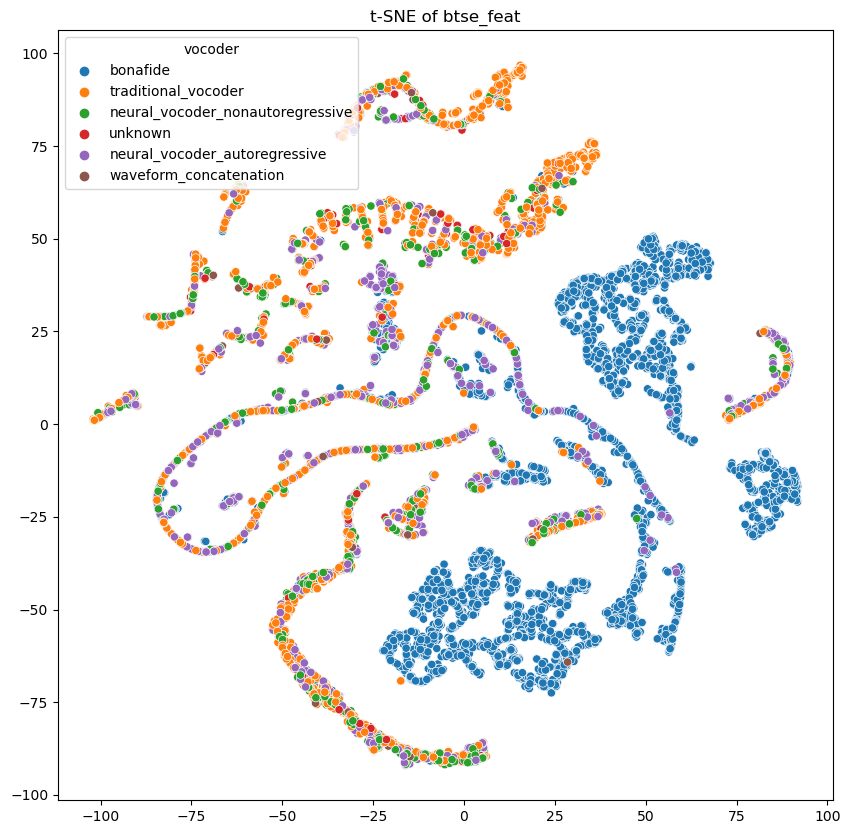

In [7]:
# visualize the features with t-SNE
# the feature is stored in btse_feat, vocosig_feat, aasistssl_feat
# the label is stored in DF21_10000['label']
category = 'vocoder'
# t-SNE
# btse_feat
btse_feat = np.array(btse_feat)
btse_feat = btse_feat.reshape(btse_feat.shape[0], -1)
btse_feat_embedded = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(btse_feat)
DF21_10000['btse_feat_embedded'] = list(btse_feat_embedded)

# show plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x=btse_feat_embedded[:,0], y=btse_feat_embedded[:,1], hue=DF21_10000[category])
plt.title('t-SNE of btse_feat')
plt.savefig('./figs/b_tsne_btse_{}.png'.format(category), dpi=400)
plt.show()



/home/phucdt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phucdt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...


[t-SNE] Computed neighbors for 10000 samples in 3.818s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.188540
[t-SNE] Computed conditional probabilities in 0.258s
[t-SNE] Iteration 50: error = 96.4799805, gradient norm = 0.0114207 (50 iterations in 4.103s)
[t-SNE] Iteration 100: error = 83.3977127, gradient norm = 0.0049189 (50 iterations in 4.069s)


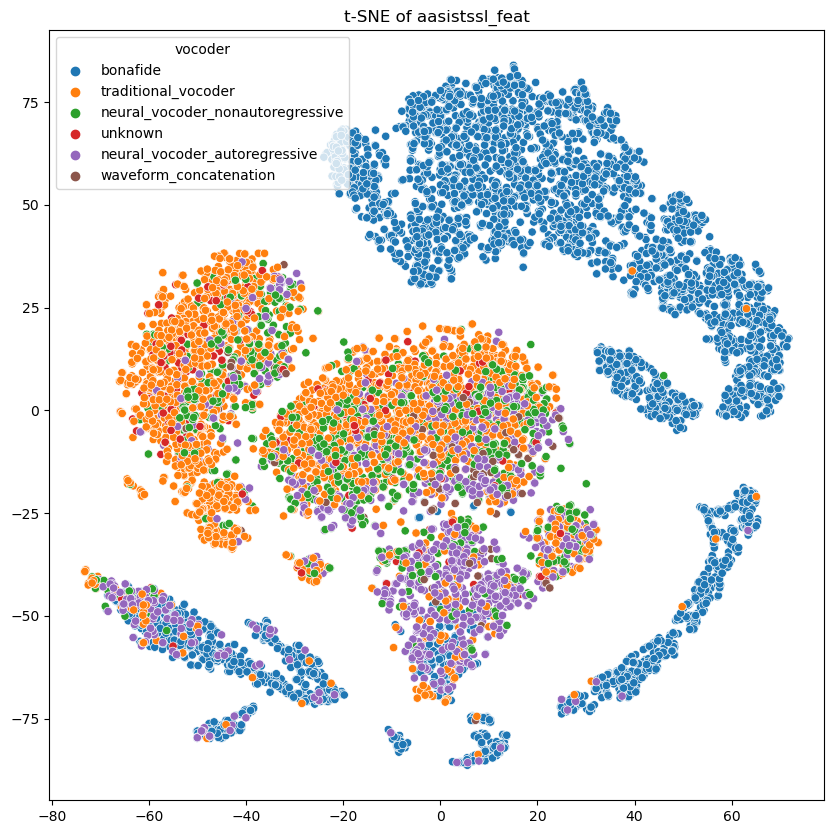

In [8]:
# visualize the features with t-SNE
# the feature is stored in btse_feat, vocosig_feat, aasistssl_feat
# the label is stored in DF21_10000['label']
category = 'vocoder'
# t-SNE
# aasistssl_feat
aasistssl_feat = np.array(aasistssl_feat)
aasistssl_feat = aasistssl_feat.reshape(aasistssl_feat.shape[0], -1)
aasistssl_feat_embedded = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(aasistssl_feat)
DF21_10000['aasistssl_feat_embedded'] = list(aasistssl_feat_embedded)

# show plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x=aasistssl_feat_embedded[:,0], y=aasistssl_feat_embedded[:,1], hue=DF21_10000[category])
plt.title('t-SNE of aasistssl_feat')
plt.savefig('./figs/b_tsne_aasistssl_{}.png'.format(category), dpi=400)
plt.show()



/home/phucdt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phucdt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...


[t-SNE] Computed neighbors for 10000 samples in 2.649s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.002124
[t-SNE] Computed conditional probabilities in 0.299s
[t-SNE] Iteration 50: error = 91.3515549, gradient norm = 0.0244049 (50 iterations in 4.109s)
[t-SNE] Iteration 100: error = 74.5768814, gradient norm = 0.0049767 (50 iterations in 3.994s)


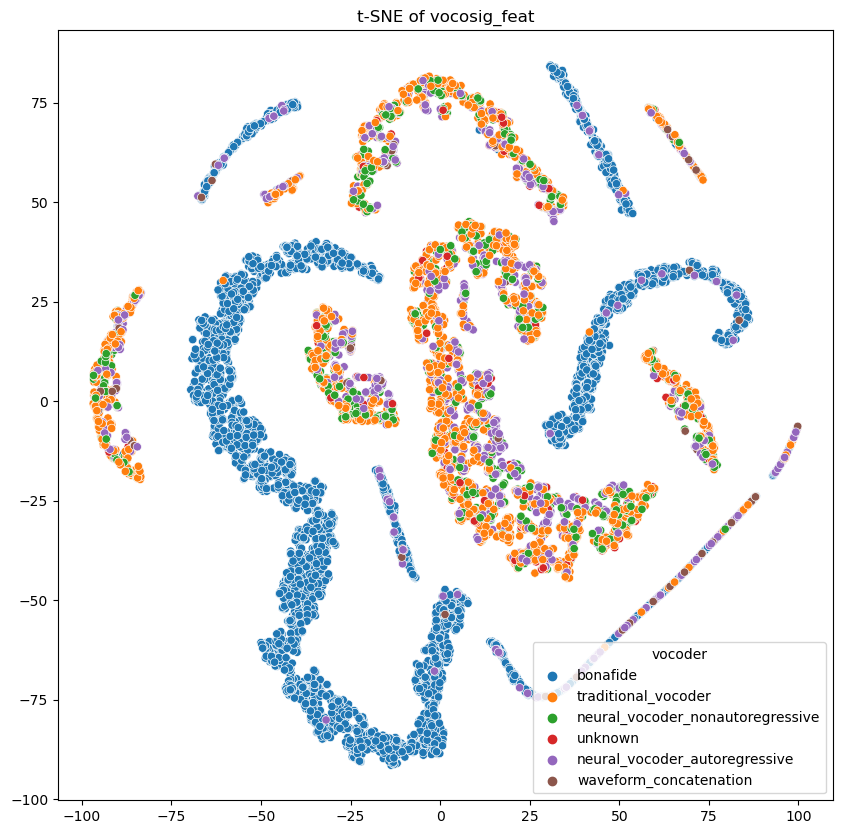

In [9]:
# visualize the features with t-SNE
# the feature is stored in btse_feat, vocosig_feat, aasistssl_feat
# the label is stored in DF21_10000['label']
category = 'vocoder'
# t-SNE
# vocosig_feat
vocosig_feat = np.array(vocosig_feat)
vocosig_feat = vocosig_feat.reshape(vocosig_feat.shape[0], -1)
vocosig_feat_embedded = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(vocosig_feat)
DF21_10000['vocosig_feat_embedded'] = list(vocosig_feat_embedded)

# show plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x=vocosig_feat_embedded[:,0], y=vocosig_feat_embedded[:,1], hue=DF21_10000[category])
plt.title('t-SNE of vocosig_feat')
plt.savefig('./figs/b_tsne_vocosig_{}.png'.format(category), dpi=400)
plt.show()




In [10]:
# save the DF21_10000
# exclude the feat columns
DF21_10000 = DF21_10000.drop(['vocosig_feat', 'aasistssl_feat', 'btse_feat'], axis=1)
DF21_10000.to_csv('./DF21_10000_balanced_tsne_included.csv', index=False)

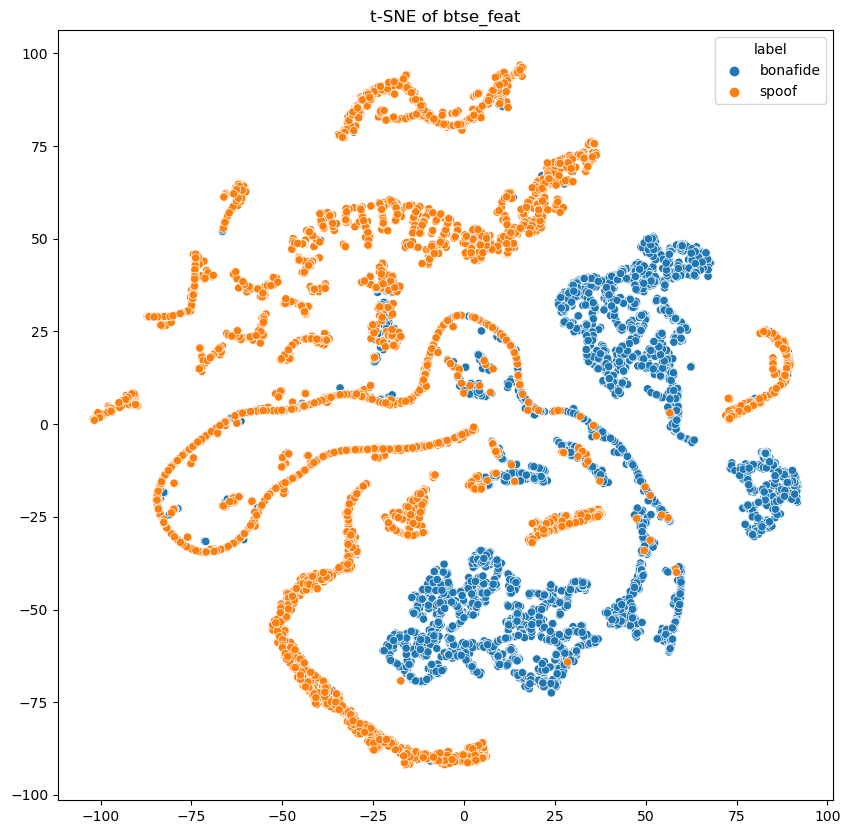

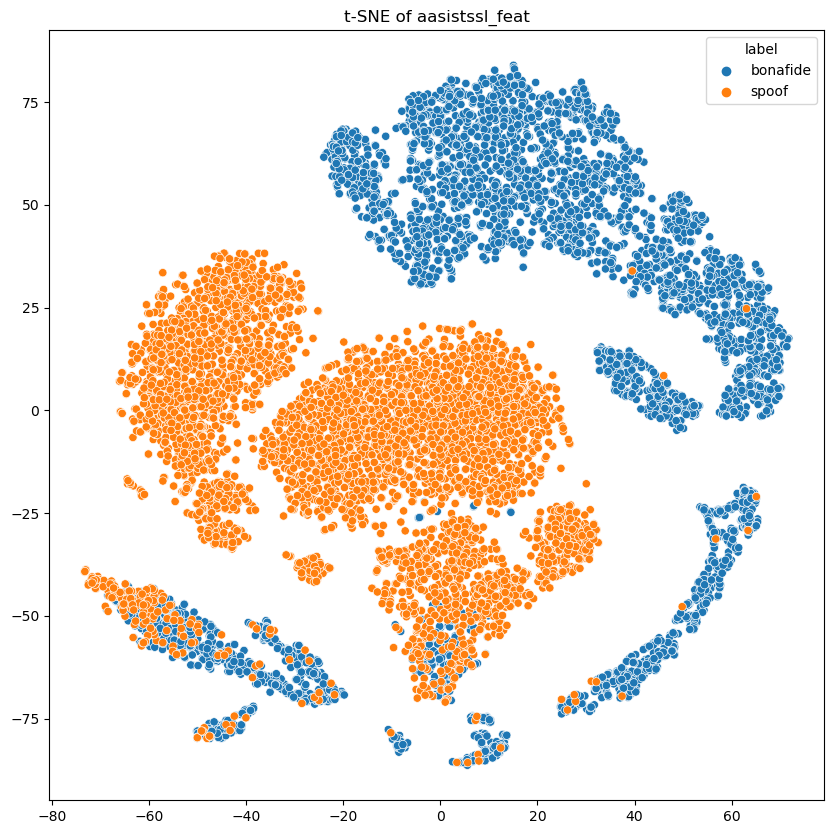

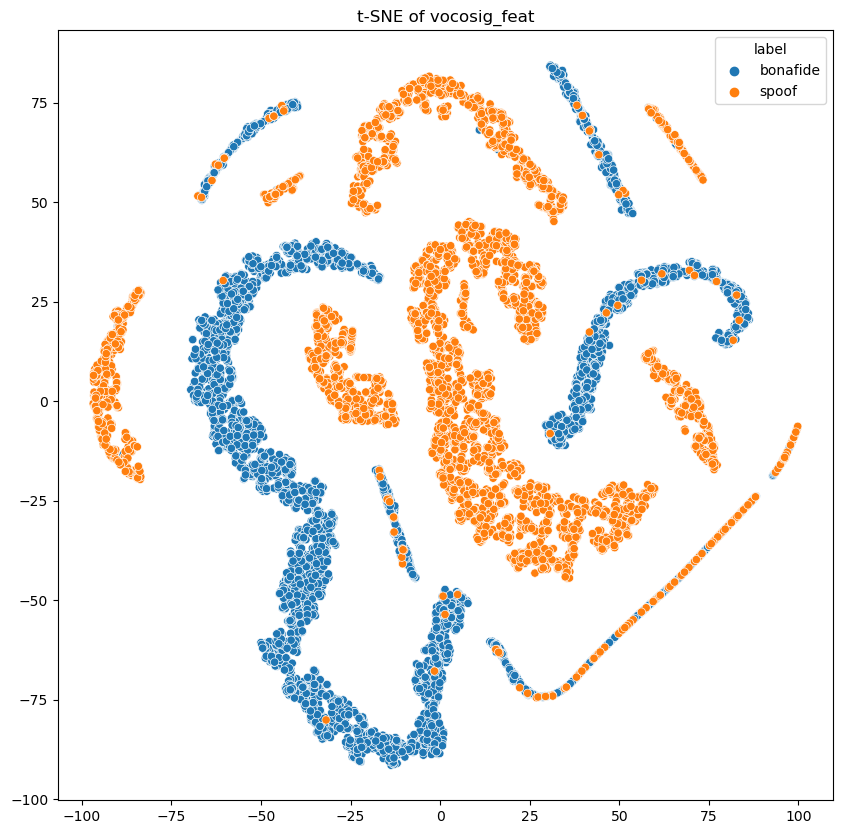

In [11]:
# Show 3 plot of a category
category = 'label'
# btse_feat
plt.figure(figsize=(10, 10))
sns.scatterplot(x=btse_feat_embedded[:,0], y=btse_feat_embedded[:,1], hue=DF21_10000[category])
plt.title('t-SNE of btse_feat')
plt.savefig('./figs/b_tsne_btse_{}.png'.format(category), dpi=400)
plt.show()

# aasistssl_feat
plt.figure(figsize=(10, 10))
sns.scatterplot(x=aasistssl_feat_embedded[:,0], y=aasistssl_feat_embedded[:,1], hue=DF21_10000[category])
plt.title('t-SNE of aasistssl_feat')
plt.savefig('./figs/b_tsne_aasistssl_{}.png'.format(category), dpi=400)
plt.show()

# vocosig_feat
plt.figure(figsize=(10, 10))
sns.scatterplot(x=vocosig_feat_embedded[:,0], y=vocosig_feat_embedded[:,1], hue=DF21_10000[category])
plt.title('t-SNE of vocosig_feat')
plt.savefig('./figs/b_tsne_vocosig_{}.png'.format(category), dpi=400)
plt.show()

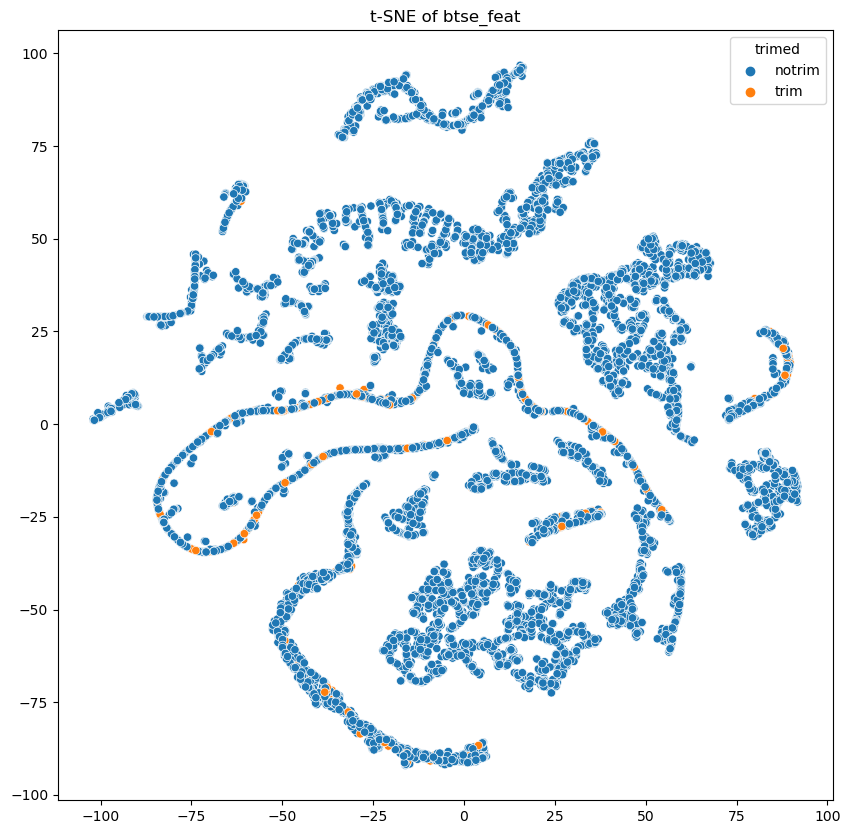

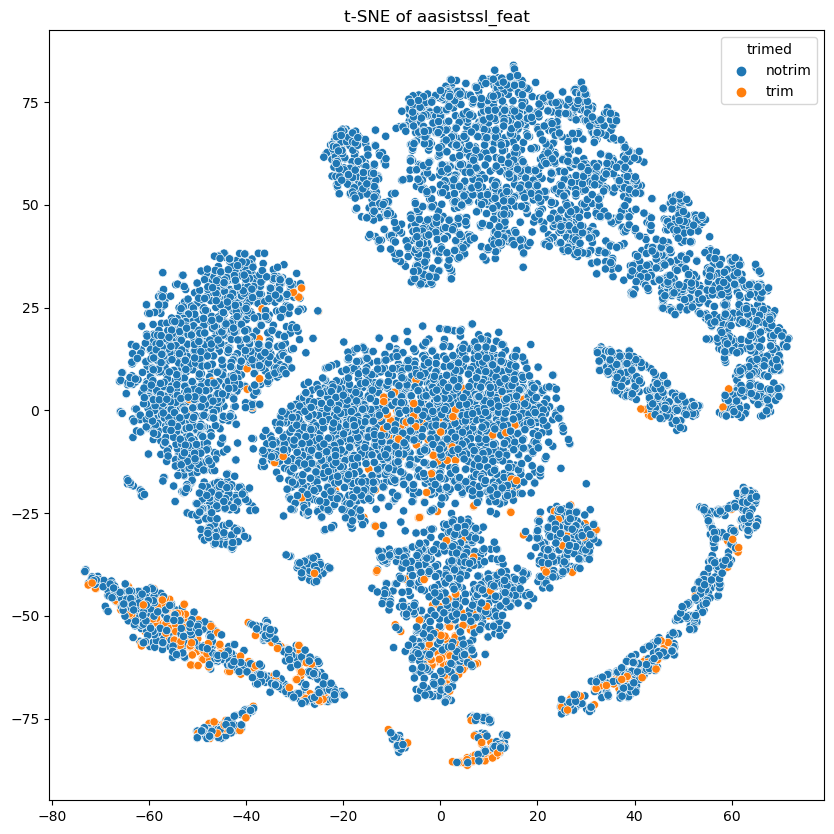

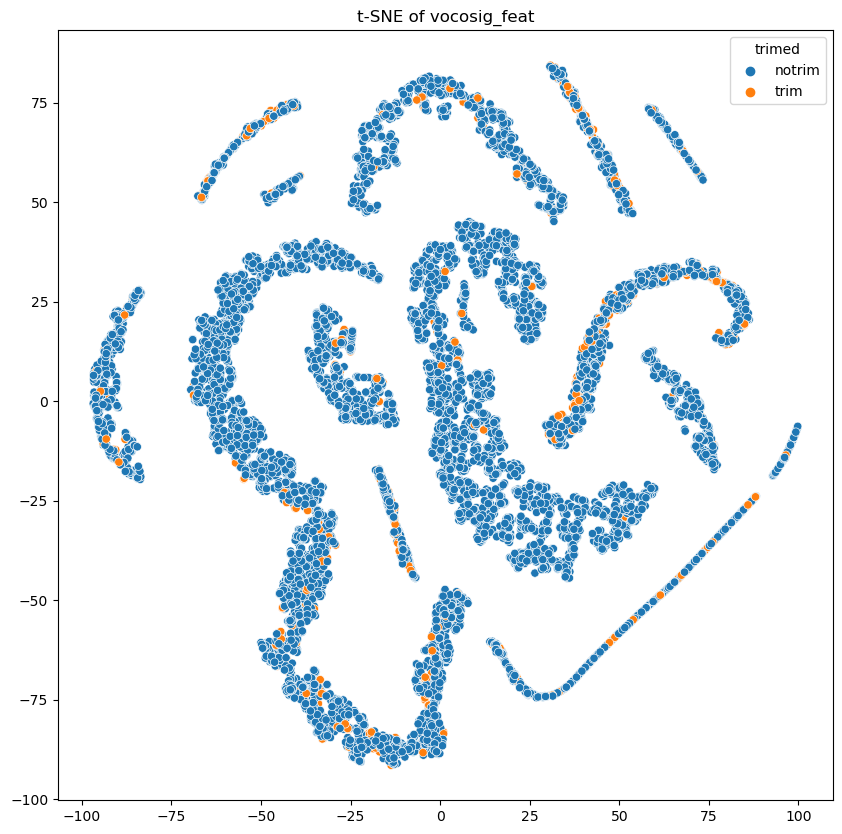

In [12]:
# Show 3 plot of a category
category = 'trimed'
# btse_feat
plt.figure(figsize=(10, 10))
sns.scatterplot(x=btse_feat_embedded[:,0], y=btse_feat_embedded[:,1], hue=DF21_10000[category])
plt.title('t-SNE of btse_feat')
plt.savefig('./figs/b_tsne_btse_{}.png'.format(category), dpi=400)
plt.show()

# aasistssl_feat
plt.figure(figsize=(10, 10))
sns.scatterplot(x=aasistssl_feat_embedded[:,0], y=aasistssl_feat_embedded[:,1], hue=DF21_10000[category])
plt.title('t-SNE of aasistssl_feat')
plt.savefig('./figs/b_tsne_aasistssl_{}.png'.format(category), dpi=400)
plt.show()

# vocosig_feat
plt.figure(figsize=(10, 10))
sns.scatterplot(x=vocosig_feat_embedded[:,0], y=vocosig_feat_embedded[:,1], hue=DF21_10000[category])
plt.title('t-SNE of vocosig_feat')
plt.savefig('./figs/b_tsne_vocosig_{}.png'.format(category), dpi=400)
plt.show()

In [21]:
# add score of each system to DF21_10000
# load score of each system
# path: ./scores/df2021
# score of vocosig
dfvocosig = pd.read_csv('./scores/df2021/vocosig.txt', sep=' ', header=None)
dfvocosig.columns = ['utt', 'spoof', 'vocosig_score']
dfvocosig.utt = dfvocosig['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
dfvocosig.drop(['spoof'], axis=1, inplace=True)
# dfvocosig.head

# score of aasistssl
dfaasistssl = pd.read_csv('./scores/df2021/aasist_ssl.txt', sep=' ', header=None)
dfaasistssl.columns = ['utt', 'spoof', 'aasistssl_score']
dfaasistssl.utt = dfaasistssl['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
dfaasistssl.drop(['spoof'], axis=1, inplace=True)
# dfaasistssl.head

# score of btse
dfbtse = pd.read_csv('./scores/df2021/btse_wav2vec.txt', sep=' ', header=None)
dfbtse.columns = ['utt', 'spoof', 'btse_score']
dfbtse.utt = dfbtse['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
dfbtse.drop(['spoof'], axis=1, inplace=True)

In [22]:
DF21_10000 = pd.read_csv('./DF21_10000_balanced_tsne_included.csv')

In [23]:
# merge score to DF21_10000
DF21_10000 = pd.merge(DF21_10000, dfvocosig, on='utt')
DF21_10000 = pd.merge(DF21_10000, dfaasistssl, on='utt')
DF21_10000 = pd.merge(DF21_10000, dfbtse, on='utt')
DF21_10000.head

<bound method NDFrame.head of           sid           utt     codec       src        attack     label  \
0     LA_0019  DF_E_3286133   low_ogg  asvspoof             -  bonafide   
1     LA_0017  DF_E_3827859   low_mp3  asvspoof             -  bonafide   
2     LA_0039  DF_E_3710666    mp3m4a  asvspoof             -  bonafide   
3     LA_0038  DF_E_2441351  high_mp3  asvspoof             -  bonafide   
4     VCC2SF2  DF_E_3270860   low_ogg   vcc2018             -  bonafide   
...       ...           ...       ...       ...           ...       ...   
9995  LA_0024  DF_E_2118638   low_mp3  asvspoof           A12     spoof   
9996     TEM2  DF_E_2242469    oggm4a   vcc2020  Task1-team19     spoof   
9997     TEF2  DF_E_4483286    oggm4a   vcc2020  Task1-team04     spoof   
9998  VCC2TF2  DF_E_4037613   low_m4a   vcc2018       HUB-D03     spoof   
9999     TEM1  DF_E_3542510  high_mp3   vcc2020  Task1-team14     spoof   

      trimed    subset                           vocoder     s1      

In [24]:
from evaluate_metrics import compute_eer

# compute eer of each system



TypeError: '<' not supported between instances of 'str' and 'float'

## CNSL_intern

In [2]:
# load CNSL_intern meta_norm.csv
intern_meta = pd.read_csv('./DATA/CNSL_intern/meta_norm.csv')
intern_meta.head

<bound method NDFrame.head of                           utt    Speaker name TTS or VC Is multi-speaker?  \
0         20230925_sbsnews5_4        REPORTER         -                No   
1          20230914sbsenter_4     NEWS CASTER         -                No   
2                   podcast_1      PARK JAEHO         -                No   
3          230926_HanJuneTV_6         HanJune         -                No   
4               230722_Deep_9     YoonTaeYong         -                No   
...                       ...             ...       ...               ...   
1861        230831_MBC_Chef_7       Lee JiSoo         -                No   
1862               TED_INCA_9  Gabriel Prieto         -                No   
1863        elle_songhyegyo_5    SONG HYE GYO         -                No   
1864  230915_YTN_northkorea_8       Um Ji Min         -                No   
1865              LOL_Combi_3  TTS_ByungChoon       TTS                No   

     Language  Gender    Age  Noise type 1  N

In [4]:
# load vocosig feature of CNSL_intern
vocosig_feat = []
for i in tqdm(range(len(intern_meta))):
    utt = intern_meta.iloc[i]['utt']
    feat = np.load('./feats/vocosig_la19_conf3_46/intern/' + utt + '.npy')
    vocosig_feat.append(feat)

100%|██████████| 1866/1866 [00:00<00:00, 2776.49it/s]


In [5]:
# load aasistssl_best_df feature of CNSL_intern
aasistssl_feat = []
for i in tqdm(range(len(intern_meta))):
    utt = intern_meta.iloc[i]['utt']
    feat = np.load('./feats/aasistssl_best_df/intern/' + utt + '.npy')
    aasistssl_feat.append(feat)
    


100%|██████████| 1866/1866 [00:00<00:00, 2799.90it/s]


In [6]:
# load wav2vec_btse feature of CNSL_intern
btse_feat = []
for i in tqdm(range(len(intern_meta))):
    utt = intern_meta.iloc[i]['utt']
    feat = np.load('./feats/wav2vec_btse/intern/' + utt + '.npy')
    btse_feat.append(feat)
    
    

100%|██████████| 1866/1866 [00:01<00:00, 1334.10it/s]


In [10]:
# Calculate TSNE of each feature
# the feature is stored in btse_feat, vocosig_feat, aasistssl_feat
# the label is stored in DF21_10000['label']
category = 'TTS or VC'
# t-SNE
# vocosig_feat
print('vocosig_feat')
vocosig_feat = np.array(vocosig_feat)
vocosig_feat = vocosig_feat.reshape(vocosig_feat.shape[0], -1)
vocosig_feat_embedded = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(vocosig_feat)
intern_meta['vocosig_feat_embedded'] = list(vocosig_feat_embedded)
print('aasistssl_feat')
aasistssl_feat = np.array(aasistssl_feat)
aasistssl_feat = aasistssl_feat.reshape(aasistssl_feat.shape[0], -1)
aasistssl_feat_embedded = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(aasistssl_feat)
intern_meta['aasistssl_feat_embedded'] = list(aasistssl_feat_embedded)
print('btse_feat')
btse_feat = np.array(btse_feat)
btse_feat = btse_feat.reshape(btse_feat.shape[0], -1)
btse_feat_embedded = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(btse_feat)
intern_meta['btse_feat_embedded'] = list(btse_feat_embedded)


vocosig_feat
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1866 samples in 0.001s...


/home/phucdt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phucdt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 1866 samples in 0.330s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1866
[t-SNE] Computed conditional probabilities for sample 1866 / 1866
[t-SNE] Mean sigma: 0.010995
[t-SNE] Computed conditional probabilities in 0.071s
[t-SNE] Iteration 50: error = 65.1680603, gradient norm = 0.0893605 (50 iterations in 3.587s)
[t-SNE] Iteration 100: error = 55.4982376, gradient norm = 0.0465911 (50 iterations in 3.482s)
[t-SNE] Iteration 150: error = 52.2421722, gradient norm = 0.0264331 (50 iterations in 3.464s)
[t-SNE] Iteration 200: error = 50.8192024, gradient norm = 0.0218995 (50 iterations in 3.479s)
[t-SNE] Iteration 250: error = 50.0355949, gradient norm = 0.0221942 (50 iterations in 3.482s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.035595
[t-SNE] Iteration 300: error = 0.5256032, gradient norm = 0.0008444 (50 iterations in 3.475s)
[t-SNE] Iteration 350: error = 0.3456759, gradient norm = 0.0003250 (50 iterations 

/home/phucdt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phucdt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed conditional probabilities in 0.067s
[t-SNE] Iteration 50: error = 69.5191040, gradient norm = 0.1529284 (50 iterations in 3.516s)
[t-SNE] Iteration 100: error = 61.2630997, gradient norm = 0.0610190 (50 iterations in 3.459s)
[t-SNE] Iteration 150: error = 59.9143486, gradient norm = 0.0361477 (50 iterations in 3.470s)
[t-SNE] Iteration 200: error = 59.3401947, gradient norm = 0.0327923 (50 iterations in 3.479s)
[t-SNE] Iteration 250: error = 59.0618477, gradient norm = 0.0390815 (50 iterations in 3.467s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.061848
[t-SNE] Iteration 300: error = 1.1278541, gradient norm = 0.0010087 (50 iterations in 3.478s)
[t-SNE] Iteration 350: error = 0.9469365, gradient norm = 0.0003738 (50 iterations in 3.471s)
[t-SNE] Iteration 400: error = 0.8897098, gradient norm = 0.0002366 (50 iterations in 3.516s)
[t-SNE] Iteration 450: error = 0.8663642, gradient norm = 0.0001803 (50 iterations in 3.474s)
[t-SNE] Iteration 5

/home/phucdt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phucdt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 1866
[t-SNE] Computed conditional probabilities for sample 1866 / 1866
[t-SNE] Mean sigma: 0.217131
[t-SNE] Computed conditional probabilities in 0.059s
[t-SNE] Iteration 50: error = 66.8762360, gradient norm = 0.0973200 (50 iterations in 3.455s)
[t-SNE] Iteration 100: error = 58.4336548, gradient norm = 0.0407417 (50 iterations in 3.474s)
[t-SNE] Iteration 150: error = 56.2849350, gradient norm = 0.0314015 (50 iterations in 3.498s)
[t-SNE] Iteration 200: error = 55.4640427, gradient norm = 0.0146981 (50 iterations in 3.472s)
[t-SNE] Iteration 250: error = 55.0133781, gradient norm = 0.0154708 (50 iterations in 3.487s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.013378
[t-SNE] Iteration 300: error = 0.6399902, gradient norm = 0.0008358 (50 iterations in 3.483s)
[t-SNE] Iteration 350: error = 0.4639145, gradient norm = 0.0003095 (50 iterations in 3.511s)
[t-SNE] Iteration 400: error = 0.4178426, grad

In [14]:
# save the intern_meta
# exclude the feat columns
# intern_meta = intern_meta.drop(['vocosig_feat', 'aasistssl_feat', 'btse_feat'], axis=1)
intern_meta.to_csv('./intern_meta_tsne_included.csv', index=False)

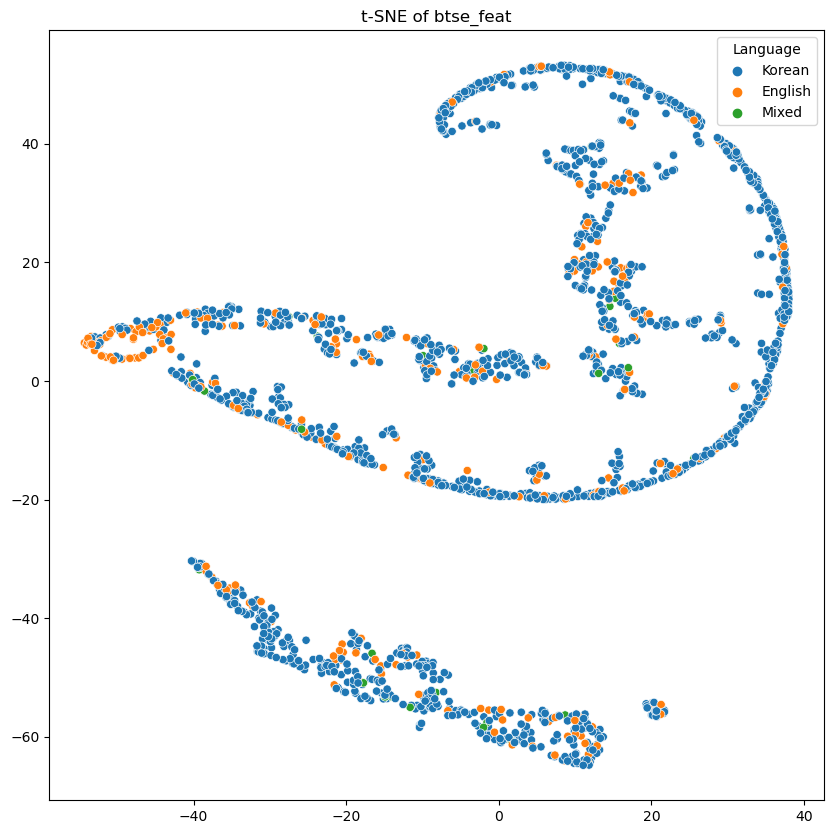

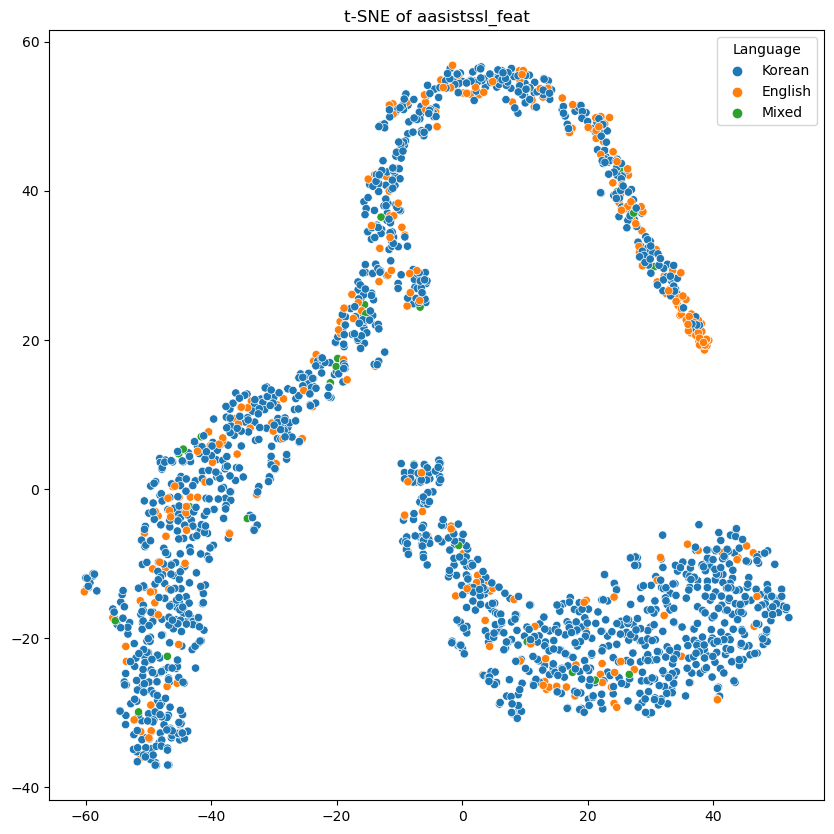

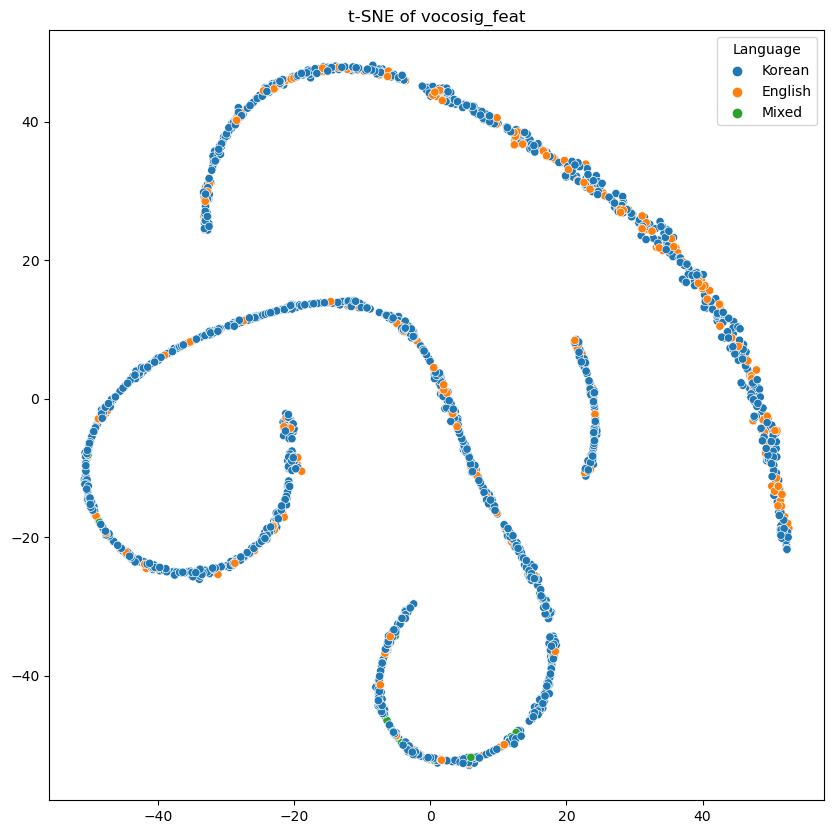

In [19]:
# Show 3 plot of a category
category = 'Language'
# btse_feat
plt.figure(figsize=(10, 10))
sns.scatterplot(x=btse_feat_embedded[:,0], y=btse_feat_embedded[:,1], hue=intern_meta[category])
plt.title('t-SNE of btse_feat')
plt.savefig('./figs/intern_tsne_btse_{}.png'.format(category), dpi=400)
plt.show()

# aasistssl_feat
plt.figure(figsize=(10, 10))
sns.scatterplot(x=aasistssl_feat_embedded[:,0], y=aasistssl_feat_embedded[:,1], hue=intern_meta[category])
plt.title('t-SNE of aasistssl_feat')
plt.savefig('./figs/intern_tsne_aasistssl_{}.png'.format(category), dpi=400)
plt.show()

# vocosig_feat
plt.figure(figsize=(10, 10))
sns.scatterplot(x=vocosig_feat_embedded[:,0], y=vocosig_feat_embedded[:,1], hue=intern_meta[category])
plt.title('t-SNE of vocosig_feat')
plt.savefig('./figs/intern_tsne_vocosig_{}.png'.format(category), dpi=400)
plt.show()

In [4]:
# load detection score of each system
print('vocosig_score')
vocosig_score = pd.read_csv('./feats/vocosig_la19_conf3_46/intern/scores.txt', sep=' ', header=None)
vocosig_score.columns = ['utt', 'spoof', 'vocosig_score']
vocosig_score.utt = vocosig_score['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
vocosig_score.drop(['spoof'], axis=1, inplace=True)
# merge score to intern_meta
intern_meta = pd.merge(intern_meta, vocosig_score, on='utt')

print('aasistssl_score')
aasistssl_score = pd.read_csv('./feats/aasistssl_best_df/intern/scores.txt', sep=' ', header=None)
aasistssl_score.columns = ['utt', 'spoof', 'aasistssl_score']
aasistssl_score.utt = aasistssl_score['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
aasistssl_score.drop(['spoof'], axis=1, inplace=True)
# merge score to intern_meta
intern_meta = pd.merge(intern_meta, aasistssl_score, on='utt')

print('btse_score')
btse_score = pd.read_csv('./feats/wav2vec_btse/intern/scores.txt', sep=' ', header=None)
btse_score.columns = ['utt', 'spoof', 'btse_score']
btse_score.utt = btse_score['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
btse_score.drop(['spoof'], axis=1, inplace=True)
# merge score to intern_meta
intern_meta = pd.merge(intern_meta, btse_score, on='utt')





vocosig_score
aasistssl_score
btse_score


In [5]:
# compute eer of each system
print('vocosig_eer')
bonafide_score = intern_meta[intern_meta['label'] == 'bonafide']['vocosig_score']
spoof_score = intern_meta[intern_meta['label'] == 'spoof']['vocosig_score']
vocosig_eer, vocosig_threshold = compute_eer(bonafide_score, spoof_score)
print('vocosig_eer: {:.2f}% with threshold: {:.2f}'.format(vocosig_eer*100, vocosig_threshold))

print('aasistssl_eer')
bonafide_score = intern_meta[intern_meta['label'] == 'bonafide']['aasistssl_score']
spoof_score = intern_meta[intern_meta['label'] == 'spoof']['aasistssl_score']
aasistssl_eer, aasistssl_threshold = compute_eer(bonafide_score, spoof_score)
print('aasistssl_eer: {:.2f}% with threshold: {:.2f}'.format(aasistssl_eer*100, aasistssl_threshold))

print('btse_eer')
bonafide_score = intern_meta[intern_meta['label'] == 'bonafide']['btse_score']
spoof_score = intern_meta[intern_meta['label'] == 'spoof']['btse_score']
btse_eer, btse_threshold = compute_eer(bonafide_score, spoof_score)
print('btse_eer: {:.2f}% with threshold: {:.2f}'.format(btse_eer*100, btse_threshold))



vocosig_eer
vocosig_eer: 32.31% with threshold: -0.01
aasistssl_eer
aasistssl_eer: 47.21% with threshold: -3.37
btse_eer
btse_eer: 48.93% with threshold: -5.61


vocosig_eer
vocosig_eer of Male: 31.84% with threshold: -0.03
vocosig_eer of Female: 29.40% with threshold: -0.00
vocosig_eer of Female+Male: nan% with threshold: -6.99
aasistssl_eer
aasistssl_eer of Male: 51.21% with threshold: -3.38
aasistssl_eer of Female: 39.19% with threshold: -3.32
aasistssl_eer of Female+Male: nan% with threshold: -3.54
btse_eer
btse_eer of Male: 52.14% with threshold: -5.29
btse_eer of Female: 44.23% with threshold: -6.18
btse_eer of Female+Male: nan% with threshold: -6.18


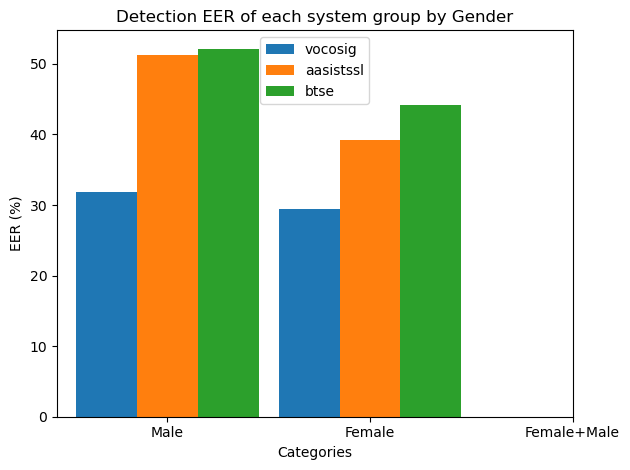

In [14]:
# compute eer of each system group by category
category = 'Gender'
catlist = intern_meta[category].unique()
print('vocosig_eer')
vocosig_res = []
aasistssl_res = []
btse_res = []
for cat in catlist:
    bonafide_score = intern_meta[(intern_meta['label'] == 'bonafide') & (intern_meta[category] == cat)]['vocosig_score']
    spoof_score = intern_meta[(intern_meta['label'] == 'spoof') & (intern_meta[category] == cat)]['vocosig_score']
    vocosig_eer, vocosig_threshold = compute_eer(bonafide_score, spoof_score)
    vocosig_res.append(vocosig_eer*100)
    print('vocosig_eer of {}: {:.2f}% with threshold: {:.2f}'.format(cat, vocosig_eer*100, vocosig_threshold))
    
print('aasistssl_eer')
for cat in catlist:
    bonafide_score = intern_meta[(intern_meta['label'] == 'bonafide') & (intern_meta[category] == cat)]['aasistssl_score']
    spoof_score = intern_meta[(intern_meta['label'] == 'spoof') & (intern_meta[category] == cat)]['aasistssl_score']
    aasistssl_eer, aasistssl_threshold = compute_eer(bonafide_score, spoof_score)
    aasistssl_res.append(aasistssl_eer*100)
    print('aasistssl_eer of {}: {:.2f}% with threshold: {:.2f}'.format(cat, aasistssl_eer*100, aasistssl_threshold))
    
print('btse_eer')
for cat in catlist:
    bonafide_score = intern_meta[(intern_meta['label'] == 'bonafide') & (intern_meta[category] == cat)]['btse_score']
    spoof_score = intern_meta[(intern_meta['label'] == 'spoof') & (intern_meta[category] == cat)]['btse_score']
    btse_eer, btse_threshold = compute_eer(bonafide_score, spoof_score)
    btse_res.append(btse_eer*100)
    print('btse_eer of {}: {:.2f}% with threshold: {:.2f}'.format(cat, btse_eer*100, btse_threshold))
    
bar_width = 0.3
index = np.arange(len(catlist))
# plot the above results in bar plot
plt.bar(index, vocosig_res, bar_width, label='vocosig')
plt.bar(index + bar_width, aasistssl_res, bar_width, label='aasistssl')
plt.bar(index + 2 * bar_width, btse_res, bar_width, label='btse')

plt.xlabel('Categories')
plt.ylabel('EER (%)')
plt.title('Detection EER of each system group by {}'.format(category))
plt.xticks(index + bar_width, catlist)
plt.legend()

plt.tight_layout()
plt.show()

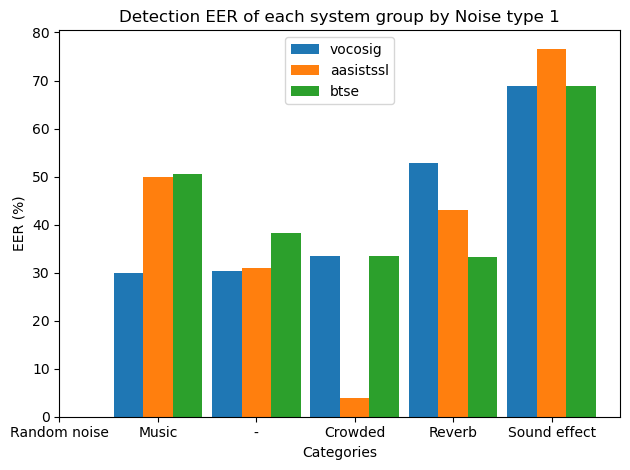

In [11]:
bar_width = 0.3
index = np.arange(len(catlist))
# plot the above results in bar plot
plt.bar(index, vocosig_res, bar_width, label='vocosig')
plt.bar(index + bar_width, aasistssl_res, bar_width, label='aasistssl')
plt.bar(index + 2 * bar_width, btse_res, bar_width, label='btse')

plt.xlabel('Categories')
plt.ylabel('EER (%)')
plt.title('Detection EER of each system group by {}'.format(category))
plt.xticks(index + bar_width, catlist)
plt.legend()

plt.tight_layout()
plt.show()